# Camera Distortion Model

In this colab we will use a deep neural networks to model a camera distortions using the pixel postions read from the camera against the pixel positions without distortion, according to OpenCV models.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Get the training file from gitlab and extract the content.

In [2]:
!wget --no-check-certificate https://gitlab.com/mparra-mpz/opencv-tensorflow/-/raw/master/data/training_data.tar.gz
!tar xvzf training_data.tar.gz

--2021-05-01 02:59:47--  https://gitlab.com/mparra-mpz/opencv-tensorflow/-/raw/master/data/training_data.tar.gz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8698690 (8.3M) [application/x-gzip]
Saving to: ‘training_data.tar.gz’

training_data.tar.g 100%[===================>]   8.29M  --.-KB/s    in 0.06s   

2021-05-01 02:59:47 (149 MB/s) - ‘training_data.tar.gz’ saved [8698690/8698690]

training_data.tf


Create a normalization function.

In [3]:
def norm(x):
  return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

Load the data from the file.

In [4]:
data_collect = np.loadtxt('training_data.tf', dtype=np.float32, comments='#')
data_collect = norm(data_collect)
np.random.shuffle(data_collect)
train_size = int(data_collect.shape[0] * 0.8)
print('Train size: %d -- Test size: %d' % (train_size, data_collect.shape[0] - train_size))

Train size: 311228 -- Test size: 77807


Split the data into training data and test data.

In [5]:
# Train data.
train_examples = data_collect[:train_size, 0:2]
x_train_labels = data_collect[:train_size, 2:3]
y_train_labels = data_collect[:train_size, 3:4]

# Test data.
test_examples = data_collect[train_size:, 0:2]
x_test_labels = data_collect[train_size:, 2:3]
y_test_labels = data_collect[train_size:, 3:4]

Create Tensorflow Datasets to manage the great number of data.

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, x_train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, x_test_labels))

BATCH_SIZE = 256

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Create and execute a model.

In [7]:
model = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(1,2)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)])

#optimizer = tf.keras.optimizers.RMSprop()
#loss = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanAbsoluteError()
metrics = [tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model structure:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 64)             192       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 256)            33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 64)             8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
____________________________________________________

Create a callback for the model.

In [11]:
REQUIRE_RMSE = 1.0e-07

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('root_mean_squared_error') < REQUIRE_RMSE:
      msg = '\nRoot mean squared error is low than %lf, so cancelling training!' % REQUIRE_RMSE
      print(msg)
      self.model.stop_training = True

callbacks = myCallback()

Train the model.

In [12]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=100, 
                    callbacks=[callbacks])

Epoch 1/100
1216/1216 [==============================] - 4s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - mean_squared_error: 9.8000e-05 - root_mean_squared_error: 0.0099 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 3.8767e-05 - val_root_mean_squared_error: 0.0062
Epoch 2/100
1216/1216 [==============================] - 4s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0275e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 9.9918e-05 - val_root_mean_squared_error: 0.0100
Epoch 3/100
1216/1216 [==============================] - 4s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - mean_squared_error: 9.3740e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164 - val_mean_squared_error: 4.0032e-04 - val_root_mean_squared_error: 0.0200
Epoch 4/100
1216/1216 [==============================] - 4s 3ms/step - lo

Plot mean square error evolution.

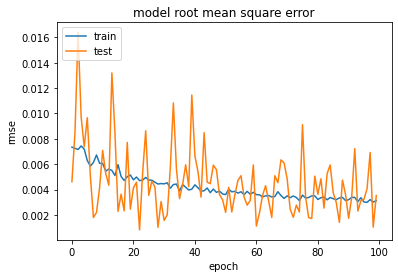

In [16]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model root mean square error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Predeict test results and compare against labels.

In [14]:
x_predictions = model.predict(test_dataset)
x_errors = x_test_labels - x_predictions
plt.title('X error Histogram')
plt.xlabel('Error [pixels]')
plt.ylabel('Points')
plt.hist(x_errors, bins=100)
plt.show()

Clean up the environment.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)